In [42]:
import os
import cv2

import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [43]:
DATA_DIR = 'data/210202_230816'

x_train_dir = os.path.join(DATA_DIR, 'train_image_512')
y_train_dir = os.path.join(DATA_DIR, 'train_annotation_512')

x_valid_dir = os.path.join(DATA_DIR, 'validation_image_512')
y_valid_dir = os.path.join(DATA_DIR, 'validation_annotation_512')

x_test_dir = os.path.join(DATA_DIR, 'test_image_512')
y_test_dir = os.path.join(DATA_DIR, 'test_annotation_512')

In [44]:
class Dataset(BaseDataset):
    """Read images, apply augmentation transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
            id2label = {0: 'intactwall', 1: 'tectonictrace', 2: 'desiccation',3: 'faultgauge', 4: 'breakout', 5: 'faultzone'}
    """
    
    CLASSES = ['intactwall', 'tectonictrace', 'inducedcrack', 'faultgauge', 'breakout', 
               'faultzone']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
    ):
        self.ids = os.listdir(images_dir)  
        self.ids.sort(key=lambda x: int(x.split('_')[-1].split('.')[0])) 
        self.ids_annotation = os.listdir(masks_dir)     
        self.ids_annotation.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids_annotation]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        # BGR-->RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        # print(self.images_fps)
        # print(self.masks_fps)
        # print(mask)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        # print(mask.shape)
        # print(mask)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image.transpose(2, 0, 1), mask.transpose(2, 0, 1)
        
    def __len__(self):
        return len(self.ids)

In [45]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if name == 'image':
            plt.imshow(image.transpose(1, 2, 0))
        else:
            plt.imshow(image)
    plt.show()

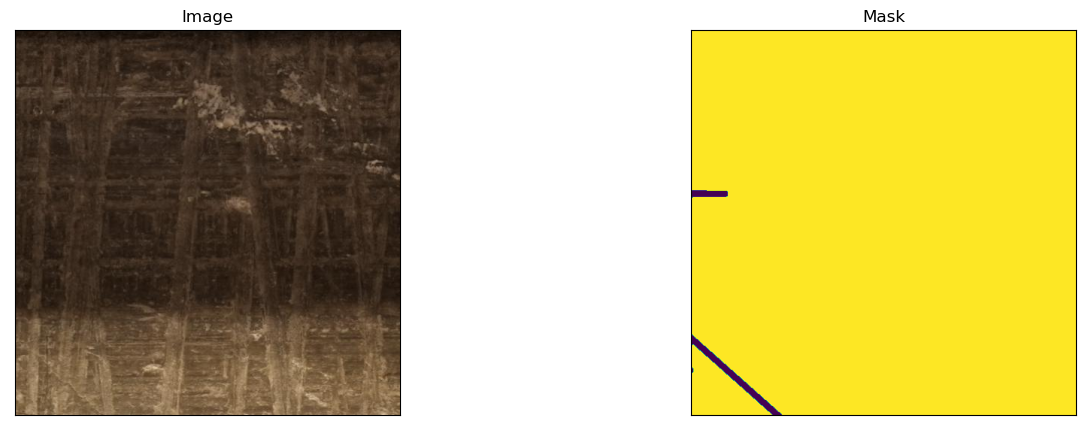

In [38]:
dataset = Dataset(x_test_dir, y_test_dir,classes = ['intactwall', 'tectonictrace', 'inducedcrack', 'faultgauge', 'breakout', 
               'faultzone'])
# get some sample
image, mask = dataset[2]
# visualize(image=image, mask=mask.squeeze(),)
visualize(image=image, mask=mask[0].squeeze())

In [46]:
# training set images augmentation
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomCrop(width=512, height=512, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5), 
        A.CLAHE(p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), p=0.1),
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        # A.PadIfNeeded(384, 480),
    ]
    return A.Compose(test_transform)

/home/wangrush/.local/lib/python3.10/site-packages/pydantic/main.py:328: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


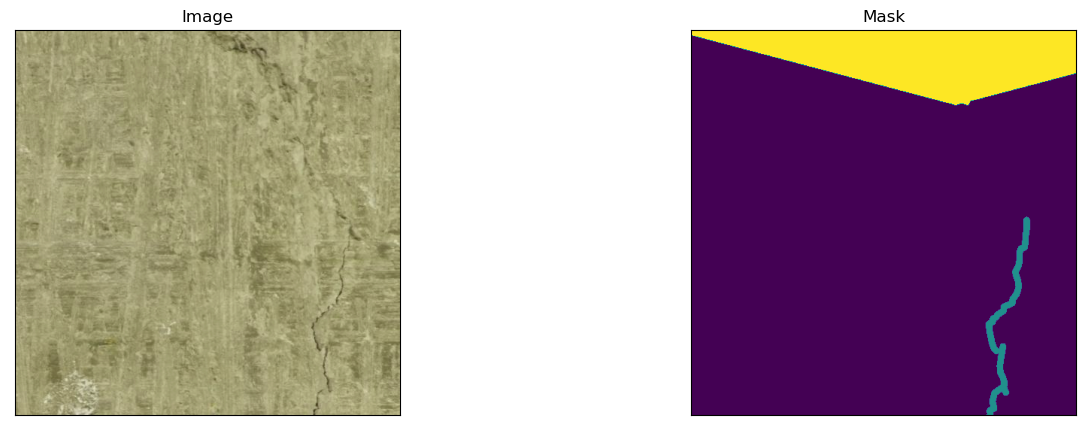

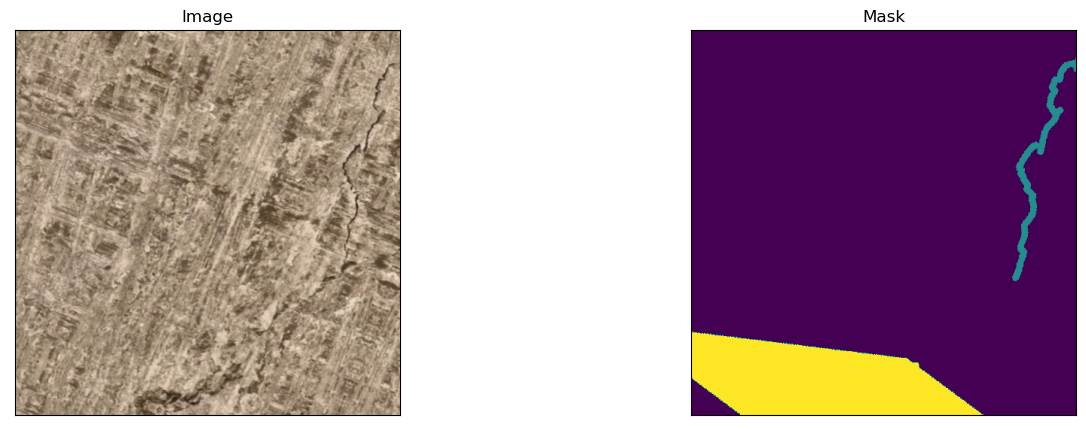

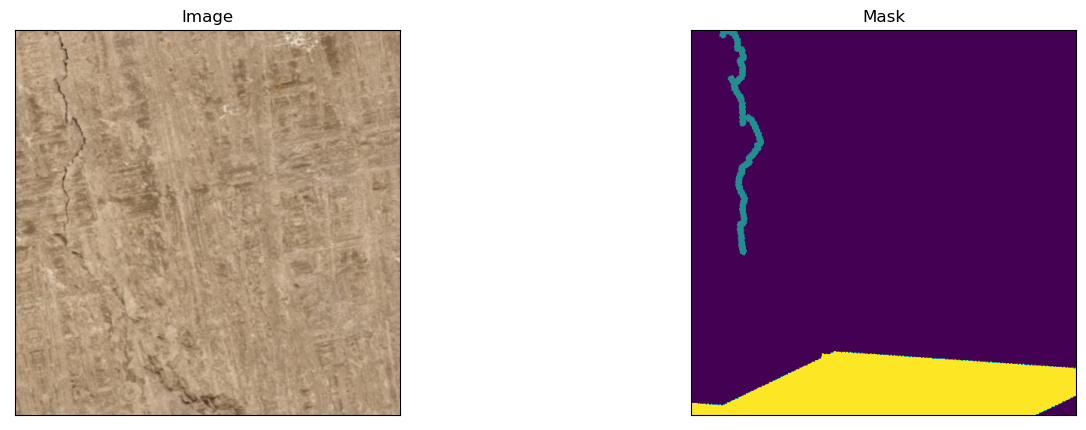

In [47]:
# Visualize resulted augmented images and masks
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes = ['intactwall', 'tectonictrace', 'inducedcrack', 'faultgauge', 'breakout', 
               'faultzone'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[3]
    visualize(image=image, mask=mask.argmax(axis = 0))

In [48]:
CLASSES = ['intactwall', 'tectonictrace', 'inducedcrack', 'faultgauge', 'breakout', 
               'faultzone']

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    classes=CLASSES,
)

test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(), 
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

FileNotFoundError: [Errno 2] No such file or directory: 'data/210202_230816/validation_image_512'

In [43]:
EPOCHS = 100
T_MAX = EPOCHS * len(train_loader)
OUT_CLASSES = 6

In [55]:
from torch import nn
from FocalLoss import FocalLoss
weights = [1.4,404.5,143.1,1619.2,4.5,13.8] 
alpha = [w / sum(weights) for w in weights]

class UnetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels = 3, out_classes = 6, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))
        
        # self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        # self.loss_fn = nn.BCEWithLogitsLoss(reduction='none').to(device)
        # self.loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights)).to(device)
        self.loss_fn = FocalLoss(alpha=torch.tensor(alpha).to(device), gamma=2, reduction='sum').to(device) 
        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch
        
        
        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4
        
        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        # masks = [(mask == v).float() for v in range(6)]
        # mask = torch.stack(masks, dim=-1)
        # mask = mask.permute(0,3,1,2)
        # print("print mask shape", mask.shape)
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0
        
        logits_mask = self.forward(image)
        gt_label = mask.argmax(axis = 0)
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, gt_label).to(device)
        
        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        # prob_mask = logits_mask.sigmoid()
        # pred_mask = (prob_mask > 0.5).float()
        
        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(logits_mask.argmax(dim=1)[0].long(), gt_label.long(), mode="multiclass")
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        
        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return 

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return 

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return 

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step',
                'frequency': 1
            }
        }
        return 

In [53]:
model = UnetModel("Unet", "resnet34", in_channels=3, out_classes=6)

In [47]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model.to(device), 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Unet             | 24.4 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.748    Total estimated model params size (MB)
189       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

ValueError: Expected input batch_size (4) to match target batch_size (6).

In [ ]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 25/25 [00:00<00:00, 35.85it/s]
[{'valid_per_image_iou': 0.7837786674499512, 'valid_dataset_iou': 0.7812573313713074}]


In [ ]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 237/237 [00:06<00:00, 36.16it/s]
[{'test_per_image_iou': 0.8510006666183472, 'test_dataset_iou': 0.8224387168884277}]


In [56]:
model_ckpt = UnetModel.load_from_checkpoint('model_ckpt/unet_model/unet_ep500_focalloss_1309.ckpt', torch.device('cpu'))

# # disable randomness, dropout, etc...
model_ckpt.eval()

from PIL import Image
n = 249
# image_test = Image.open('data/test_image_512/' + f'image_{n}.jpg')
image_test = cv2.imread('data/test_image_512/' + f'image_{n}.jpg')
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
image_test = image_test.transpose(2,0,1)
image_test = np.expand_dims(image_test, axis=0)
# predict with the model
y_hat = model_ckpt(torch.from_numpy(image_test))
print("Done!")

TypeError: UnetModel.__init__() missing 2 required positional arguments: 'arch' and 'encoder_name'

In [41]:
def mIOU(prediction, label, num_classes):
    # prediction= prediction.max(1)[1].float().cpu().numpy()
    # label = label.float().cpu().numpy() 
    
    iou_list = list()
    present_iou_list = list()
    # all_iou_list = list()

    for sem_class in range(num_classes):
        # print(sem_class)
        pred_inds = (prediction == sem_class)
        target_inds = (label == sem_class)
        if target_inds.sum().item() == 0:
            iou_now = float('nan')
            # iou_now = 0
            # all_iou_list
        else:
            # print(sem_class)
            intersection_now = (pred_inds[target_inds]).sum().item()
            union_now = pred_inds.sum().item() + target_inds.sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    miou = np.mean(present_iou_list)
    return miou, iou_list

In [ ]:
model.eval()
with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        data = images
        print(images, images.shape)
        out_data = model(data)
        break

tensor([[[[  3,  13,  15,  ...,  34,  32,  28],
          [  3,  15,  20,  ...,  36,  34,  31],
          [  3,  19,  28,  ...,  34,  33,  30],
          ...,
          [ 10,  70,  76,  ..., 105, 107, 114],
          [ 14,  65,  78,  ..., 108, 120, 138],
          [ 11,  58,  80,  ..., 114, 135, 160]],

         [[  0,  10,   7,  ...,  27,  25,  21],
          [  0,  12,  12,  ...,  29,  27,  24],
          [  0,  16,  20,  ...,  27,  26,  23],
          ...,
          [  0,  58,  60,  ...,  81,  83,  90],
          [  2,  53,  62,  ...,  84,  96, 114],
          [  0,  46,  64,  ...,  90, 111, 136]],

         [[  0,   5,   4,  ...,  21,  19,  15],
          [  0,   7,   9,  ...,  23,  21,  18],
          [  0,  11,  17,  ...,  19,  18,  15],
          ...,
          [  0,  42,  44,  ...,  53,  55,  62],
          [  0,  37,  46,  ...,  56,  68,  86],
          [  0,  30,  48,  ...,  62,  83, 108]]],


        [[[ 17,  18,  19,  ...,  23,  24,  27],
          [ 18,  20,  21,  ...,  26

In [ ]:
out_data.shape

torch.Size([4, 6, 512, 512])

In [ ]:
m_accuracy=list()
mean_IOU = list()
perClass_IOU = np.arange(6)

model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        # Forward pass through the model
        logits = model(images)
        
        # Apply sigmoid to convert logits to probabilities
        pr_masks = logits.sigmoid()
        
        # Iterate through the batch and process each image/mask pair
        for i, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
            # Your code for processing each image, ground truth mask, and predicted mask
            # For example, you might want to save the results, calculate metrics, etc.
            gt_seg = gt_mask.argmax(axis = 0).numpy()
            pr_seg = pr_mask.argmax(axis = 0).numpy()
            acc = np.mean((pr_seg == gt_seg))
            m_accuracy.append(acc)
            m_iou,iou_list = mIOU(pr_seg,gt_seg,6)
            iou_arr = np.array(iou_list)
            mean_IOU.append(m_iou)
            perClass_IOU = np.vstack([perClass_IOU,iou_arr])

print("Overall mean IOU:",np.mean(mean_IOU))
print("Overall mean Acc:",np.mean(m_accuracy))
perClass_IOU = perClass_IOU[1:]
print("Per class IOU:", np.nanmean(perClass_IOU,axis = 0))

Overall mean IOU: 0.5153049017911701
Overall mean Acc: 0.8850687097620081
Per class IOU: [0.92490795 0.         0.         0.         0.48095115 0.        ]


In [ ]:
print("Overall mean IOU:",np.mean(mean_IOU))
print("Overall mean Acc:",np.mean(m_accuracy))
perClass_IOU = perClass_IOU[1:]
print("Per class IOU:", np.nanmean(perClass_IOU,axis = 0))

Overall mean IOU: 0.6021137327351891
Overall mean Acc: 0.9604072570800781
Per class IOU: [0.9605427 0.              nan       nan       nan       nan]


/tmp/ipykernel_4075554/3516445121.py:4: RuntimeWarning: Mean of empty slice
  print("Per class IOU:", np.nanmean(perClass_IOU,axis = 0))
